In [3]:
import csv

#!pip install pandas
import pandas as pd

In [4]:
data = pd.read_csv(r"newVersion-2Cleaned.csv")


In [5]:
data2 = pd.read_csv(r"AraDepSu Dataset.csv")

In [6]:
data.columns= ['labels',"tweets"]
data2.columns= ['tweets',"labels"]

In [7]:
# make sure every row in each df is not duplicated
resData = data2["tweets"].to_frame().merge(data["tweets"].to_frame(), how = 'inner' ,indicator=False)

In [8]:
data['labels'] = data['labels'].replace([1, 2], [1, 0])
data2['labels'] = data2['labels'].replace(['Non-depression', 'Depression Mood',"Depression With Suicidal Ideation"], [0,1,1])

In [9]:
#to swap data columns: column1 for tweets and column2 for labels
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [10]:
data = swap_columns(data, 'labels', 'tweets')


In [11]:
#concat the two df together
allData= pd.concat([data, data2], axis=0)


In [12]:
allData["labels"].value_counts()

0.0    13103
1.0     8168
Name: labels, dtype: int64

In [13]:
# drop duplicated rows
allData= allData.drop_duplicates(keep='first')

In [14]:
newdf = allData.dropna()


In [15]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21234 entries, 0 to 20213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tweets  21234 non-null  object 
 1   labels  21234 non-null  float64
dtypes: float64(1), object(1)
memory usage: 497.7+ KB


0.0    13088
1.0     8146
Name: labels, dtype: int64


<Axes: ylabel='Type'>

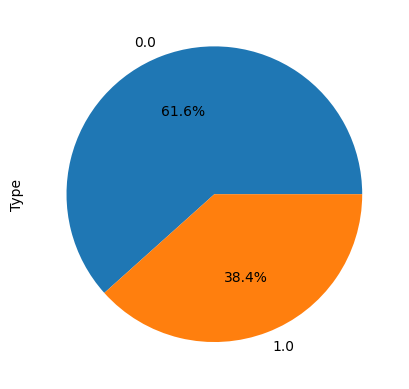

In [16]:
print(newdf["labels"].value_counts())

newdf.groupby('labels').size().plot(kind='pie',
                                       y = "labels",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [17]:
nonDep0 = newdf[newdf["labels"] == 0.0]
dep1  = newdf[newdf["labels"] == 1.0]
print(nonDep0.shape)
print(dep1.shape)

(13088, 2)
(8146, 2)


In [18]:
from sklearn.utils import resample
nonDep0_downsample = resample(nonDep0,
             replace=True,
             n_samples=len(dep1),
             random_state=42)

print(nonDep0_downsample.shape)

(8146, 2)


0.0    8146
1.0    8146
Name: labels, dtype: int64


<Axes: ylabel='Type'>

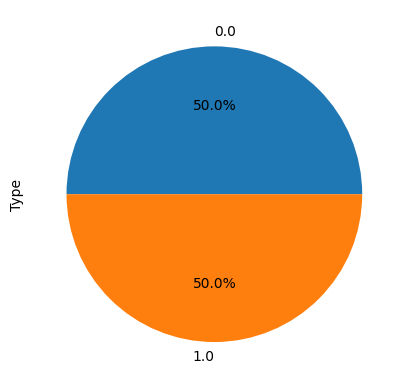

In [19]:
newdf2 = pd.concat([nonDep0_downsample, dep1])

print(newdf2["labels"].value_counts())

newdf2.groupby('labels').size().plot(kind='pie',
                                       y = "labels",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [20]:
newdf2

,tweets,labels
7882,فقد عجزت الكلمات,0.0
1467,والله الهيئة دم حامي و ما بتقبل انتقادات يعني ...,0.0
5997,كمية خمول في هذه الإجازة مش طبيعية والله,0.0
5798,دموعنا ليست رخيصة ولكن انهكنا الحنين,0.0
16156,ابي كل شي ابيض عشان اشوفه بسكل اوضح واتأمل لحد...,0.0
...,...,...
20205,يا انجز يا اموت نفسي بس🤏🏽.,1.0
20207,اموت نفسي طيب و لا اعمل ايه,1.0
20208,ابغى اتخلص من عادة اني اشوف نفسي احق بذا الشيء...,1.0
20209,نفسي أموت بقي يا ولاد,1.0


In [21]:
!pip install transformers
!git clone https://github.com/aub-mind/arabert
!pip install -r arabert/requirements.txt

!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
^C
fatal: destination path 'arabert' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached emoji-1.4.2-py3-none-any.whl
  Attempting uninstall: emoji
    Found existing installation: emoji 1.6.1
    Uninstalling emoji-1.6.1:
      Successfully uninstalled emoji-1.6.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.12.2-py3-none-any.whl (3.1 MB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 

In [22]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from arabert.preprocess import ArabertPreprocessor
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy
from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, cohen_kappa_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [23]:
model_name = "aubmindlab/bert-base-arabertv02-twitter"
arabert_prep = ArabertPreprocessor(model_name=model_name)
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN thi

In [24]:
arabic_prep = ArabertPreprocessor(model_name)

newdf2["tweets"] = newdf2["tweets"].apply(lambda x: arabic_prep.preprocess(x))

In [25]:
x=pd.DataFrame()
x["encoded"]=newdf2["tweets"].apply(lambda x: tokenizer.encode(x,add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


In [26]:
x

,encoded
7882,"[2, 1166, 29061, 8725, 3]"
1467,"[2, 8808, 1698, 1839, 53240, 139, 394, 10511, ..."
5997,"[2, 6452, 2173, 314, 305, 450, 19141, 533, 822..."
5798,"[2, 25682, 325, 2066, 29738, 847, 889, 9862, 2..."
16156,"[2, 12890, 459, 1375, 41480, 26291, 1933, 4473..."
...,...
20205,"[2, 1955, 25135, 1955, 644, 573, 6599, 1841, 6..."
20207,"[2, 644, 573, 6599, 6893, 139, 391, 33833, 140..."
20208,"[2, 1394, 7329, 682, 3348, 306, 4766, 17460, 1..."
20209,"[2, 6599, 58481, 1818, 1955, 44348, 3]"


In [27]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "tweets" #"text"
LABEL_COLUMN = "labels" #"label"

In [28]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [29]:
data_label = newdf2[["tweets","labels"]]
data_label.columns = [DATA_COLUMN, LABEL_COLUMN]

train, test = train_test_split(data_label, test_size=0.2)
label_list = sorted(data_label['labels'].unique())

data = CustomDataset("Dataset", train, test, label_list)

In [30]:
tok = AutoTokenizer.from_pretrained(model_name)

In [31]:
max_len = 212

In [32]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = text.split("*|*|*")

      #inputs = tokenizer.encode_plus(text[0],text[1], max_length=self.max_len, padding = "max_length", truncation = True,  return_attention_mask = True, return_tensors = "pt")

      inputs = self.tokenizer( #################################################
          text[0],

          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )

      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [33]:
label_map = { v:index for index, v in enumerate(data.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    data.train[DATA_COLUMN].to_list(),
    data.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    data.test[DATA_COLUMN].to_list(),
    data.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{0.0: 0, 1.0: 1}


In [34]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [35]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='weighted')
  macro_precision = precision_score(p.label_ids,preds,average='weighted')
  macro_recall = recall_score(p.label_ids,preds,average='weighted')
  kappa = cohen_kappa_score(p.label_ids,preds)
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,

      'precision': macro_precision,
      'recall': macro_recall,
      'Kappa' : kappa,
      'accuracy': acc
  }

In [36]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False
!pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
training_args = TrainingArguments(
    #change to token in huggi
    output_dir= "depressionDetectionArabert",
    push_to_hub=True,
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 8,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'accuracy',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)


In [38]:
!pip install huggingface_hub


#put here the access token in your hugging face account
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('hf_#########')"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
#start the training
trainer.train()

In [ ]:
name_of_token = "depressionDetectionArabert"

trainer.push_to_hub(name_of_token)

tokenizer.push_to_hub(name_of_token)



In [ ]:
import gradio as gr

gr.Interface.load("models/ahdhd55/depressionDetectionArabert").launch(share=True)


In [ ]:
!git clone https://huggingface.co/spaces/ahdhd55/DepressionDetection

In [ ]:
!pip install gradio